### Distances to Parks / Water

Given shapefiles of the various parks and water featuers in the city of chicago, how far are each of the trap locations from each park/ water feature.  

Then using SVD, create variables upon which to regress upon

In [2]:
import pickle

#data = [df,spray,(weather_st1, weather_st2)]

with open('cleanData.pickle', 'rb') as f:
    data = pickle.load(f)
    
df = data[0]

In [3]:
import shapefile
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd

In [4]:
from os import listdir
from os.path import isfile, join

parkDir = './AddData/Parks/'
waterDir = './AddData/Water/'

parks = [f for f in listdir(parkDir) if isfile(join(parkDir,f)) if f.count('.csv') ==0]
water = [f for f in listdir(waterDir) if isfile(join(waterDir,f))if f.count('.csv') ==0]

parkShape = parkDir + parks[0].split('.')[0]
waterShape = waterDir + water[0].split('.')[0]

In [5]:
psf = shapefile.Reader(parkShape)
wsf = shapefile.Reader(waterShape)

parkSR = psf.shapeRecords()
waterSR = wsf.shapeRecords()

In [6]:
parkSR[0].record[19] ## Area of park

1.14

In [7]:
parkSize = {}
for s in parkSR:
    parkSize[s.record[4]] = s.record[19]

In [8]:
len(waterSR[0].shape.points)

790

In [9]:
# Create cKDTree functions in Dict

# Key: Identifier (number for water, park name for park)
# Value: cKDTree function built on all the points associated with water/park feature

waterFinder={}
for i, s in enumerate(waterSR):
    waterFinder[i] = cKDTree(s.shape.points)

parkFinder = {}
for s in parkSR:
    parkFinder[s.record[4]] = cKDTree(s.shape.points)

In [10]:
# Builds Distance Dictionaries:
# Key 1: Unique Location from DF
# Key 2: water/park ID
# Value: Distance from K1 to K2 (and park size for parks)

uniqueLocs = df['Location'].unique()
parkDist = {}
waterDist = {}

for l in uniqueLocs:
    parkDist[l] = {}
    waterDist[l] = {}
    
    for k in parkFinder:
        parkDist[l][k]= (parkFinder[k].query(l,1)[0], parkSize[k])
    
    for k in waterFinder:
        waterDist[l][k] = waterFinder[k].query(l,1)[0]

### Code Below For Script

In [11]:
import shapefile
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.decomposition import TruncatedSVD

# Park and water shapefile locations
parkDir = './AddData/Parks/'
waterDir = './AddData/Water/'

#######
# Builds, then returns a dictionary of parksize, parkFinder, and waterFinder
#######
def buildWaterAndParkDicts(parkDir, waterDir):

    # Park and water shapefile names
    parks = [f for f in listdir(parkDir) if isfile(join(parkDir,f)) if f.count('.csv') ==0]
    water = [f for f in listdir(waterDir) if isfile(join(waterDir,f))if f.count('.csv') ==0]

    parkShape = parkDir + parks[0].split('.')[0]
    waterShape = waterDir + water[0].split('.')[0]

    # Read in shapefiles, then the shapes/records
    psf = shapefile.Reader(parkShape)
    wsf = shapefile.Reader(waterShape)

    parkSR = psf.shapeRecords()
    waterSR = wsf.shapeRecords()

    # Create a parksize dictionary, keyed on parkname
    parkSize = {}
    for s in parkSR:
        parkSize[s.record[4]] = s.record[19]

    # Create cKDTree functions in Dict

    # Key: Identifier (number for water, park name for park)
    # Value: cKDTree function built on all the points associated with water/park feature

    waterFinder={}
    for i, s in enumerate(waterSR):
        waterFinder[i] = cKDTree(s.shape.points)

    parkFinder = {}
    for s in parkSR:
        parkFinder[s.record[4]] = cKDTree(s.shape.points)
    
    return parkSize, parkFinder, waterFinder

In [12]:
ps, pf, wf = buildWaterAndParkDicts(parkDir, waterDir)

In [22]:
from sklearn.decomposition import TruncatedSVD
def yeildParkSVD(parkSize, parkFinder, uniqueLocs, TruncSVD = 'calc', comps = 4):
    
    parkDist = {}
    
    for l in uniqueLocs:
        parkDist[l] = {}
        for k in parkFinder:
            dist = parkFinder[k].query(l,1)[0]
            size = parkSize[k]
            parkDist[l][k] = (dist, size, size/(dist**2))
    
    parkDF = pd.DataFrame()
    parkDF = parkDF.from_dict(parkDist)
    parkDF = parkDF.transpose()
    parkDF.index = [idx for idx in parkDF.index]
    
    for c in parkDF:
        parkDF[c+' Area'] = [e[1] for e in parkDF[c]]
        #parkDF[c+ ' Effect'] = [e[2] for e in parkDF[c]]
        parkDF[c] = [e[0] for e in parkDF[c]]
    
    if TruncSVD == 'calc':
        TruncSVD = TruncatedSVD(n_components = comps)
        TruncSVD.fit(parkDF)
    
    toRet = TruncSVD.transform(parkDF)
    
    toRet = pd.DataFrame(toRet, index = parkDF.index)
    return toRet, TruncSVD    

In [23]:
pdf, ptsvd = yeildParkSVD(ps, pf, uniqueLocs, comps = 6)

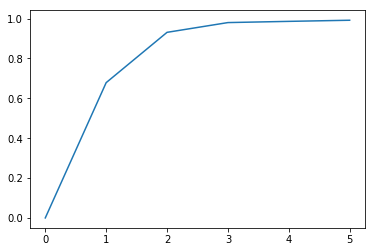

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(6), ptsvd.explained_variance_ratio_.cumsum());

In [25]:
ptsvd.explained_variance_ratio_.cumsum()

array([  9.65493381e-07,   6.78534936e-01,   9.30910545e-01,
         9.79852589e-01,   9.85957425e-01,   9.91574609e-01])

In [16]:
pdf.head(2)

,0,1,2,3,4,5
"(-87.930995, 41.957799)",15659.729641,3853.46179,3827.455257,4010.159684,2838.195238,2600.721306
"(-87.890615, 41.974689)",21658.491035,4478.92493,4321.933261,5544.188179,3330.429771,4322.334759


In [17]:
from sklearn.decomposition import TruncatedSVD
def yeildWaterSVD(waterFinder, uniqueLocs, TruncSVD = 'calc', comps = 4):
    
    waterDist = {}
    
    for l in uniqueLocs:
        waterDist[l] = {}
        for k in waterFinder:
            waterDist[l][k] = waterFinder[k].query(l,1)[0]
    
    waterDF = pd.DataFrame()
    waterDF = waterDF.from_dict(waterDist)
    waterDF = waterDF.transpose()
    waterDF.index = [idx for idx in waterDF.index]
     
    if TruncSVD == 'calc':
        TruncSVD = TruncatedSVD(n_components = comps)
        TruncSVD.fit(waterDF)
    
    toRet = TruncSVD.transform(waterDF)
    
    toRet = pd.DataFrame(toRet, index = waterDF.index)
    return toRet, TruncSVD    

In [18]:
wdf, wtsvd = yeildWaterSVD(wf, uniqueLocs, comps = 6)

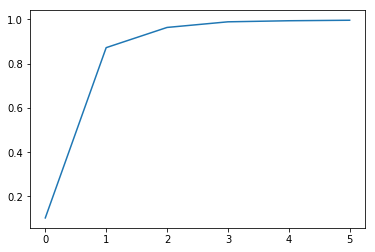

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(6), wtsvd.explained_variance_ratio_.cumsum());

In [20]:
wtsvd.explained_variance_ratio_.cumsum()

array([ 0.10318219,  0.87208568,  0.96334826,  0.98877267,  0.9936156 ,
        0.99588372])

In [90]:
wdf.head(2)

,0,1,2,3,4,5
"(-87.930995, 41.957799)",7.452501,-2.415331,2.122308,-0.353222,0.585042,0.305456
"(-87.890615, 41.974689)",6.846056,-2.593422,1.839218,-0.280489,0.525015,0.210701


## Deprecated

In [11]:
# Dictionary For water features where:
# Key: Location
# Value: Distance to nearest water feature

distToWater = {}
for k in waterDist:
    distToWater[k] = min(waterDist[k].values())

# Dictionary for park features where:
# Key: Unique Location
# Value: Sum of proximity influence of all parks
# Proximity influence based on inverse square law:
# sum of all [ area of park / (distance to park)^2]

parkProx = {}

for k in parkDist:
    proxVal = 0
    for k2 in parkDist[k]:
        current = parkDist[k][k2]
        #print(current[1])
        #print(current[0]**2)
        proxVal += current[1] / ((1*current[0])**2)
    
    parkProx[k] = proxVal